In [1]:
!nvidia-smi

Tue Dec  7 04:50:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls

drive  sample_data


In [4]:
!pip install timm
!pip install albumentations==0.4.6
!pip install torch_optimizer
!pip install imblearn
# !pip install ttach
# !pip install wandb

     |████████████████████████████████| 376 kB 13.7 MB/s 
     |████████████████████████████████| 117 kB 14.7 MB/s 
     |████████████████████████████████| 948 kB 52.6 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=52961be4af314eacd0d0fa20788728692c6f1e58e9daca44467475306202d3a8
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
     |████████████████████████████████| 61 kB 510 kB/s 


In [ ]:
# wandb login

In [5]:
import sys
import os
from datetime import datetime
import time
import random
import cv2
import gc
from tqdm.auto import tqdm
from glob import glob
import warnings
warnings.filterwarnings("ignore")
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import GradScaler, autocast

import timm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, fbeta_score
from sklearn.metrics import accuracy_score, confusion_matrix

from imblearn.over_sampling import SMOTE, RandomOverSampler

%matplotlib inline

In [6]:
BASE_DIR = '/content/drive/MyDrive/PBL06/output/'
TRAIN_GOOD_DIR =  '/content/drive/MyDrive/PBL06/output/train_normal_ch1'
TRAIN_BAD_DIR =  '/content/drive/MyDrive/PBL06/output/train_anormal_ch1'

In [ ]:
class KirikoDataset(Dataset):
    def __init__(self, df, image_dir, phase='train', transforms=None, config=None):
        super().__init__()
        self.df = df
        self.image_dir = image_dir
        self.transforms = transforms
        self.phase = phase
        
        if config:
            self.img_size = config.img_size
        else:
            self.img_size = 512

    def __getitem__(self, index: int):
        image, label = self.load_image_and_label(index)
        label = torch.as_tensor(label, dtype=torch.int64)

        if self.transforms:
            image = self.transforms(phase=self.phase, img_size=self.img_size)(**{"image": image})['image']

        return image, label

    def __len__(self) -> int:
        return len(self.df)

    #ガンマ補正(m.kiyoさん)
    def create_gamma_img(self, gamma, img):
        gamma_cvt = np.zeros(256, dtype=np.uint8)
        for i in range(256):
            gamma_cvt[i] = 255 * (float(i) / 255) ** (1.0 / gamma)

        return cv2.LUT(img, gamma_cvt)

    def load_image_and_label(self, index):
        # read image data
        image_id = self.df['filename'].values[index]
        label = self.df['porosity'].values[index] # 鋳巣の有無
        image = cv2.imread(f'{self.image_dir}/{image_id}')
        image = self.create_gamma_img(2, image)
        image = image[:, :, ::-1]
        
        return image, label

In [ ]:
class CFG:
    ##### notebook setting ####
    seed = 42

    ##### training setting ####
    img_size = 384
    out_dim = 1
    nfolds = 5
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model_arch = "swin_base_patch4_window12_384" # timmにあるモデル指定
    pretrained = True
    num_workers = 2 # Windowsの人は0推奨
    batch_size = 16
    num_epochs = 15
    accum_iter = 1
    lr = 1e-5

    optim_params = dict(lr=lr,
                        weight_decay=0.6)

    # class_weights = torch.tensor([14.]).to(device, dtype=torch.float) # データの分布見て適当に決めました
    loss_params = dict(pos_weight = None)
    
    # scheduler_params = dict(base_lr = lr,
    #                         max_lr = lr * 100,
    #                         step_size_up = 15, 
    #                         cycle_momentum = False)
    
    # scheduler_params = dict(mode='min', 
    #                         factor=0.5, 
    #                         patience=2, 
    #                         threshold=0.001, 
    #                         threshold_mode='rel', 
    #                         cooldown=0, 
    #                         min_lr=0, 
    #                         verbose=False,)
    
    scheduler_params = dict(gamma = 0.95)

    folder = f'{BASE_DIR}/{model_arch}_2/model' # モデルの保存先指定
    verbose = True
    verbose_step = 1

In [ ]:
# 画像augmentation
def get_transforms(phase: str, img_size=512):
    if phase == 'train':
        return A.Compose(
            [
                A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0., rotate_limit=0., p=0.5),
                A.RandomBrightness(limit=(0., 0.1), p=0.5),
                A.RandomScale(scale_limit=0.01, p=0.5),
                A.Resize(height=img_size, width=img_size, p=1.0),
                A.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.)),
                ToTensorV2(p=1.0)
            ],
            p=1.0
        )
    else:
        return A.Compose(
            [
                A.Resize(height=img_size, width=img_size, p=1.0),
                A.Normalize(mean=(0., 0., 0.), std=(1., 1., 1.)),
                ToTensorV2(p=1.0)
            ],
            p=1.0
        )

In [ ]:
def KirikoDataloader(df, image_dir, config, phase: str):
    assert phase == 'train' or 'test' or 'valid'
    dataset = KirikoDataset(df=df, 
                            image_dir=image_dir, 
                            phase=phase, 
                            transforms=get_transforms,
                            config=config)
    
    if phase == 'test':
        return DataLoader(dataset,
                          batch_size=config.batch_size,
                          num_workers=config.num_workers,
                          drop_last=False,
                          shuffle=False,
                          pin_memory=True)

    elif phase == 'valid':
        return DataLoader(dataset,
                          batch_size=config.batch_size,
                          num_workers=config.num_workers,
                          drop_last=False,
                          shuffle=False,
                          pin_memory=True)

    else:
        return DataLoader(dataset,
                          batch_size=config.batch_size,
                          num_workers=config.num_workers,
                          drop_last=False,
                          shuffle=True,
                          pin_memory=True)

In [ ]:
import torch.nn as nn
class KirikoModel(nn.Module):
    def __init__(self, config, in_chans=3):

        super(KirikoModel, self).__init__()
        model_arch = config.model_arch
        out_dim = config.out_dim
        pretrained = config.pretrained
        self.backbone = timm.create_model(model_arch, pretrained=pretrained, in_chans=in_chans)

        if model_arch == 'tf_efficientnet_b0_ns':
            self.n_features = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Linear(self.n_features, out_dim)
        elif model_arch == 'swin_base_patch4_window12_384':
            num_features = self.backbone.num_features
            self.backbone.head = nn.Linear(num_features, out_dim)

    def forward(self, x):
        output = self.backbone(x)
        # output = F.log_softmax(output, dim=1)
        return output

In [ ]:
def seed_everything(seed=42, is_tensorflow=False, is_torch=False, verbose=True):

    import os
    import random
    import numpy
    os.environ['PYTHONHASHSEED'] = str(seed) # os
    random.seed(seed) # random
    np.random.seed(seed) # numpy

    if is_tensorflow:
        import tensorflow as tf
        tf.random.set_seed(seed)
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
        tf.config.threading.set_inter_op_parallelism_threads(1)
        tf.config.threading.set_intra_op_parallelism_threads(1)

    if is_torch:
        import torch
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # True: 再現性なくなるが、計算速くなる False: 再現性が担保されるが、計算遅くなる

    if verbose:
        print(f'set random seed: {seed}')

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
class Runner:

    def __init__(self, model, config,
                 OptimClass, LossClass, SchedulerClass,
                 WandbClass=None, fold=None):
        self.config = config
        self.epoch = 0
        self.base_dir = f'{config.folder}'
        if not os.path.exists(self.base_dir): os.makedirs(self.base_dir)
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.model = model
        self.model = self.model.to(self.device)
        self.fold = fold

        params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = OptimClass(params, **config.optim_params)
        self.loss_func = LossClass(**config.loss_params).to(self.device)
        self.scheduler = SchedulerClass(self.optimizer, **config.scheduler_params)
        self.scaler = GradScaler()
        self.log(f'\nRunner prepared. Device is {self.device}')

        if WandbClass:
            self.is_wandb = True
            self.wandb = WandbClass
            self.wandb.watch(self.model)
        else:
            self.is_wandb = False

    def fit(self, train_loader, valid_loader):
        self.log(f'**************** FOLD {self.fold} ****************')
        for e in range(self.config.num_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            # ----------train------------
            t = time.time()
            summary_loss, acc, auc, f1 = self.train_one_epoch(train_loader)
            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch + 1}, summary_loss: {summary_loss.avg:.5f}, acc: {acc:.5f}, auc: {auc:.5f}, f1: {f1:.5f}, time: {(time.time() - t):.5f}'
            )
#             self.save(f'{self.base_dir}/last-checkpoint-fold{self.fold}.bin')
            # --------------------------

            # --------validation--------
            t = time.time()
            summary_valloss, val_acc, val_auc, val_f1 = self.validation(valid_loader)
            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch + 1}, summary_loss: {summary_valloss.avg:.5f}, val_acc: {val_acc:.5f}, val_auc: {val_auc:.5f}, val_f1: {val_f1:.5f}, time: {(time.time() - t):.5f}'
            )
            # --------------------------

            if summary_valloss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_valloss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-fold{self.fold}-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-fold{self.fold}-*epoch.bin'))[:-3]: # save best 3 epochs
                    os.remove(path)

            # self.scheduler.step(metrics=summary_valloss.avg)
            self.scheduler.step()
            self.epoch += 1

    def predict(self, data_loader, is_tta=False, verbose=True):
        self.model.eval()
        y_pred = []

        if is_tta:
            tta_transforms = tta.Compose(
                [
                    # tta.HorizontalFlip(),
                    # tta.VerticalFlip(),
                    tta.Rotate90(angles=[0, 180]),
                ]
            )
            tta_model = tta.ClassificationTTAWrapper(self.model, tta_transforms)

        t = time.time()
        for step, batch in enumerate(data_loader):
            if verbose:
                print(
                    f'pred Step {step + 1}/{len(data_loader)}, ' + \
                    f'time: {(time.time() - t):.5f}', end='\r'
                )
            with torch.no_grad():
                data, target = batch
                data = data.to(self.device, non_blocking=True)

                if is_tta:
                    output = tta_model(data)
                else:
                    output = self.model(data.float())

                # ------------Calculating accuracy---------------------
                y_pred += [ output.sigmoid().detach().cpu().numpy() ]

        y_pred = np.concatenate(y_pred)
        print(f'[DONE PRED]')
        return y_pred

    def validation(self, val_loader):
        self.model.eval()
        summary_valloss = AverageMeter()
        y_pred = []
        y_true = []

        t = time.time()
        for step, (data, target) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step + 1}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_valloss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).float()
            with torch.no_grad():
                with autocast():
                    output = self.model(data)

                    # -------------Calculate validation losses------------
#                     target_oh = torch.nn.functional.one_hot(target, num_classes=self.config.out_dim).float()
#                     loss = self.loss_func(output, target_oh)
                    loss = self.loss_func(output, target.view(-1,1))
                    loss_value = loss.item()

                # ------------Calculating accuracy---------------------
                y_pred += [ output.sigmoid().detach().cpu().numpy() ]
                y_true += [ target.detach().cpu().numpy() ]

                summary_valloss.update(loss_value, self.config.batch_size)

        y_score = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        auc = roc_auc_score(y_true, y_score)
        
        y_pred = np.where(y_score < 0.5, 0, 1)
        acc = accuracy_score(y_true, y_pred.astype('int'))
        f1 = f1_score(y_true, y_pred.astype('int'), average='binary')

        if self.is_wandb:
            self.wandb.log({'val_loss': summary_valloss.avg, 'val_auc': auc, 'val_f1': f1, 'val_f2': f2})

        return summary_valloss, acc, auc, f1


    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        y_pred = []
        y_true = []

        # --------------start--------------
        t = time.time()
        for step, (data, target) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step + 1}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            # ------------Calculate training losses--------------
            data = data.to(self.device, non_blocking=True)
            target = target.to(self.device, non_blocking=True).float()

            with autocast():
                output = self.model(data.float())

#                 target_oh = torch.nn.functional.one_hot(target, num_classes=self.config.out_dim).float()
#                 loss = self.loss_func(output, target_oh)
                loss = self.loss_func(output, target.view(-1,1))
                loss_value = loss.item()

                self.scaler.scale(loss).backward()
                
                if ((step + 1) %  CFG.accum_iter == 0) or ((step + 1) == len(train_loader)):
                    self.scaler.step(self.optimizer)
                    self.scaler.update()
                    self.optimizer.zero_grad()
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()

            summary_loss.update(loss_value, self.config.batch_size)

            y_pred += [ output.sigmoid().detach().cpu().numpy() ]
            y_true += [ target.detach().cpu().numpy() ]

        y_score = np.concatenate(y_pred)
        y_true = np.concatenate(y_true)
        auc = roc_auc_score(y_true, y_score)
        
        y_pred = np.where(y_score < 0.5, 0, 1)
        acc = accuracy_score(y_true, y_pred.astype('int'))
        f1 = f1_score(y_true, y_pred.astype('int'), average='binary')

        if self.is_wandb:
            self.wandb.log({'loss': summary_loss.avg, 'auc': auc, 'f1': f1, 'f2': f2})

        return summary_loss, acc, auc, f1

    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [ ]:
OptimClass = torch.optim.Adam
LossClass = nn.BCEWithLogitsLoss
SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
# SchedulerClass = torch.optim.lr_scheduler.CyclicLR
SchedulerClass = torch.optim.lr_scheduler.ExponentialLR

In [ ]:
net = KirikoModel(config=CFG)
runner = Runner(model=net, config=CFG,
                OptimClass=OptimClass, 
                LossClass=LossClass, 
                SchedulerClass=SchedulerClass,
                fold=0)

# テストデータ
val_loader = KirikoDataloader(df=test, 
                              image_dir=IMAGE_DIR,
                              config=CFG, 
                              phase='valid')

model_pathes = sorted(glob(f'{CFG.folder}/best-checkpoint-fold0-*epoch.bin'))


Runner prepared. Device is cuda


In [ ]:
runner.load(model_pathes[-1])

score = runner.predict(val_loader, is_tta=False, verbose=False).reshape(-1)
test['porosity_score'] = score

[DONE PRED]


best threshold:  0.75


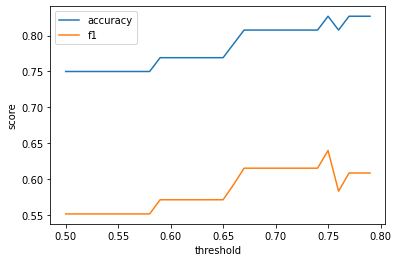

In [ ]:
threshold = [ 0.5 + 0.01 * i for i in range(30) ]

acc = []
f = []
for t in threshold:
    test['porosity_pred'] = np.where(score < t, 0, 1).astype('int')
    test_before = test.groupby('filename_old')[['porosity', 'porosity_pred']].sum().reset_index()
    test_before['porosity'] = np.where(test_before['porosity'].values < 1, 0, 1)
    test_before['porosity_pred'] = np.where(test_before['porosity_pred'].values < 1, 0, 1)

    accuracy = accuracy_score(test_before['porosity'], test_before['porosity_pred'])
    f1 = f1_score(test_before['porosity'], test_before['porosity_pred'], average='binary')

    acc.append(accuracy)
    f.append(f1)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(threshold, acc, label='accuracy')
ax.plot(threshold, f, label='f1')
ax.legend()
ax.set_xlabel("threshold")
ax.set_ylabel("score")


print('best threshold: ', threshold[np.argmax(f, axis=0)])

================Prediction Result=======================
Accuracy score: 0.9817307692307692
AUC score: 0.9365203252032519
F1 score: 0.4571428571428572


Text(83.40000000000006, 0.5, 'truth')

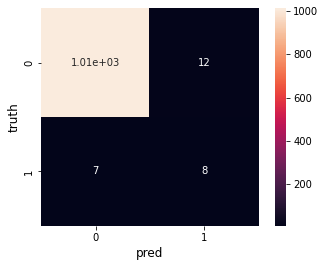

In [ ]:
test['porosity_pred'] = np.where(score < 0.75, 0, 1).astype('int')
accuracy = accuracy_score(test['porosity'], test['porosity_pred'])
auc = roc_auc_score(test['porosity'], test['porosity_score'])
f1 = f1_score(test['porosity'], test['porosity_pred'], average='binary')

print('================Prediction Result=======================')
print(f'Accuracy score: {accuracy}')
print(f'AUC score: {auc}')
print(f'F1 score: {f1}')

cm = confusion_matrix(test['porosity'], test['porosity_pred'])
sns.heatmap(cm, square=True, cbar=True, annot=True, fmt='.3g')
plt.xlabel("pred", fontsize=12)
plt.ylabel("truth", fontsize=12)

# 分割前

In [ ]:
test_before = test.groupby('filename_old')[['porosity', 'porosity_pred']].sum().reset_index()
test_before['porosity'] = np.where(test_before['porosity'].values < 1, 0, 1)
test_before['porosity_pred'] = np.where(test_before['porosity_pred'].values < 1, 0, 1)

================Prediction Result=======================
Accuracy score: 0.8269230769230769
F1 score: 0.64


Text(83.40000000000006, 0.5, 'truth')

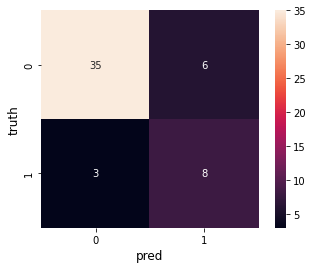

In [ ]:
accuracy = accuracy_score(test_before['porosity'], test_before['porosity_pred'])
f1 = f1_score(test_before['porosity'], test_before['porosity_pred'], average='binary')

print('================Prediction Result=======================')
print(f'Accuracy score: {accuracy}')
print(f'F1 score: {f1}')

cm = confusion_matrix(test_before['porosity'], test_before['porosity_pred'])
sns.heatmap(cm, square=True, cbar=True, annot=True, fmt='.3g')
plt.xlabel("pred", fontsize=12)
plt.ylabel("truth", fontsize=12)

In [ ]:
result = test[['filename_old', 'filename', 'porosity', 'porosity_pred']]

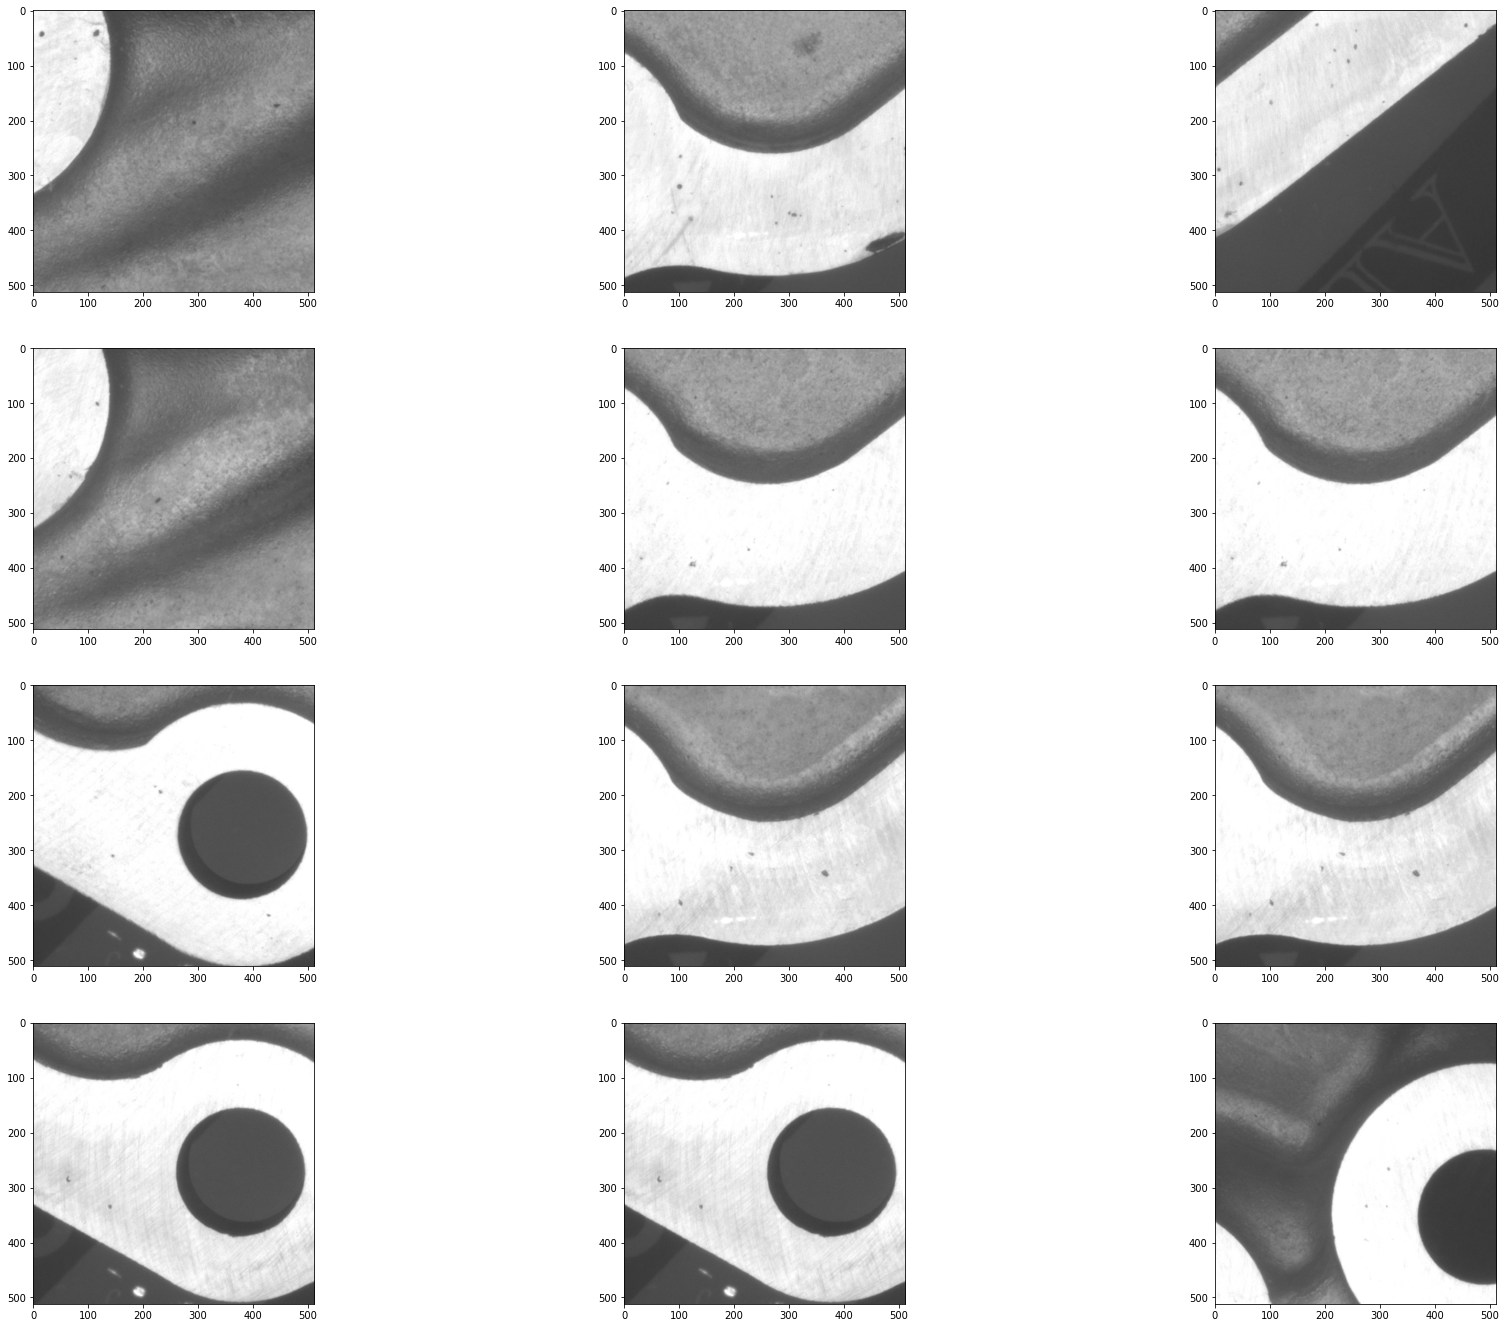

In [ ]:
# 「鋳巣なし」を「鋳巣あり」と見てしまっている
error = result[(result['porosity'] == 0) & (result['porosity_pred'] == 1)].reset_index(drop=True)
plt.figure(figsize=(30, 30))
for i in range(len(error)):
    image_id = error['filename'].values[i]

    image = cv2.imread(f'{IMAGE_DIR}/{image_id}')
    image = image[:, :, ::-1]
    plt.subplot(5, int((len(error) / 5) + 1), i+1)
    plt.imshow(image)

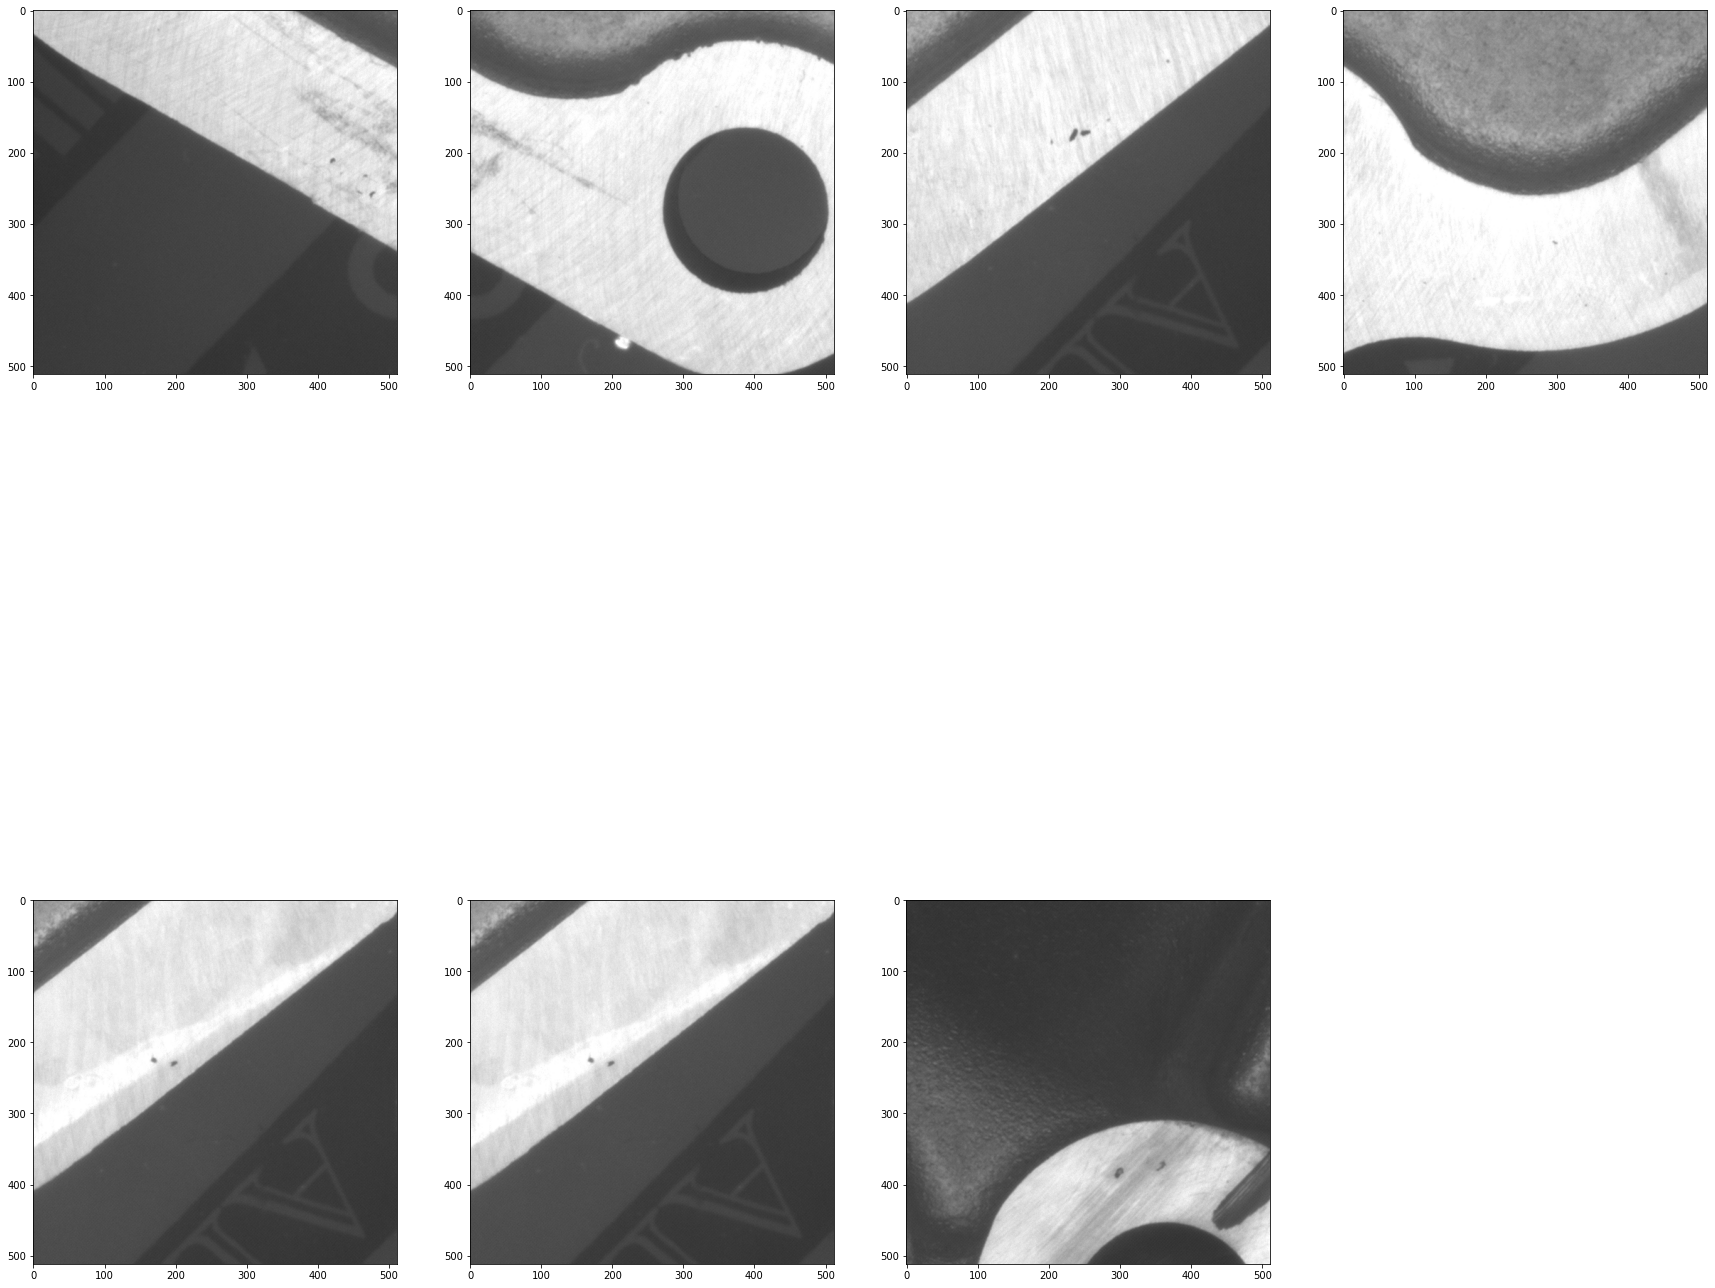

In [ ]:
# 「鋳巣あり」を「鋳巣なし」と見てしまっている
error = result[(result['porosity'] == 1) & (result['porosity_pred'] == 0)].reset_index(drop=True)
plt.figure(figsize=(30, 30))
for i in range(len(error)):
    image_id = error['filename'].values[i]

    image = cv2.imread(f'{IMAGE_DIR}/{image_id}')
    image = image[:, :, ::-1]
    plt.subplot(2, int((len(error) / 2) + 1), i+1)
    plt.imshow(image)